In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 1

In [3]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 2,
    "fundamental_value": 10,
    "std_fundamental": 0.0001,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 4,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 1.8, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "horizon_min": 1,
    "horizon_max": 8,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 3,
    "total_hft_money": 2000,
    "hft_speed": 1,
}

# Initialisation

In [4]:
# 1 initalise model objects
high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)

# Simulation

In [5]:
#%%timeit
hfms = []
lfts = []
obs = []
for n_hft in range(20):
    parameters["n_hft"] = n_hft 
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    high_frequency_traders, low_frequency_traders, orderbook = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed=1)
    hfms.append(high_frequency_traders)
    lfts.append(low_frequency_traders)
    obs.append(orderbook)

C:\Users\joerischasfoort\Documents\GitHub\hfm-abm\hft_model.py:18: RuntimeWarning: divide by zero encountered in true_divide
  adj_factor = np.divide(1., sum(all_speed))


0.0285588404017
-0.0660785891912
0.165616468853
0.174018226853
0.162466506588
0.162466506588
0.00616189455007
0.010205531435
-0.0802215695767
-0.0802215695767
-0.0160797003184
0.00460620516928
-0.100610444548
-0.100610444548
0.0784424597103
0.0204956321697
0.0359461299578
0.0359461299578
0.0359461299578
0.0238867959314
0.0334383986955
0.0334383986955
-0.0474341685847
-0.0763198798288
-0.178467340988
0.0487126480337
0.0514055915518
-0.0552430592038
0.0110012585128
0.00456875690554
-0.0592081461268
0.00456875690554
-0.0207778493362
0.00761857483484
0.0383320662334
0.00839012607629
0.00840128352129
0.0144862384001
0.0144862384001
0.0187713222744
0.0231042512947
0.192291982718
0.0276215035908
0.0276215035908
-0.0153428861338
-0.0153428861338
0.00114240829935
0.00280030180871
0.00308024609486
0.264623581856
0.264623581856
0.218874605019
-0.000999999999999
-0.000999999999999
-0.000297157848923
-0.00129715784892
-0.00129715784892
-0.000395203011315
-0.000395203011315
0.0125306764287
-0.006938

# Spreads tighten

In [6]:
mean_bid_asks = []
for ob in obs:
    bid_ask = [(ask - bid / np.mean(ask - bid)) / 2 for bid, ask in zip(ob.highest_bid_price_history, ob.lowest_ask_price_history)]
    # quoted bid_ask_spread = (Ask - Bid / Mid) / 2
    bid_ask = list(filter(lambda x: x >0, bid_ask))
    mean_bid_asks.append(np.mean(bid_ask))

(0, 19.957096774193548)

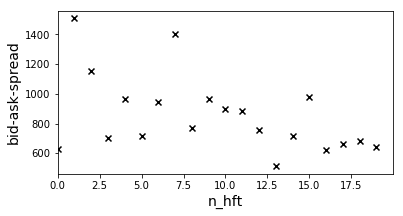

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(mean_bid_asks)), mean_bid_asks, c='k', marker='x', label='Bid-ask')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)
#fig.savefig('auto_correlation.png')

# Volume increases

In [8]:
volume = []
for ob in obs:
    total_tick_volume = [sum(volumes) for volumes in ob.transaction_volumes_history]
    volume.append(sum(total_tick_volume))

(0, 19.957096774193548)

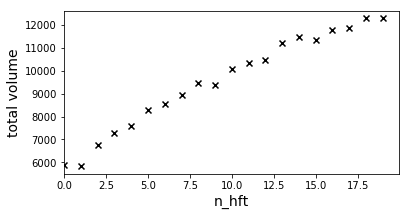

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volume)), volume, c='k', marker='x')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('total volume', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Volatility decreases

In [10]:
volatility = []
for ob in obs:
    end_tick_price = ob.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
    returns = pd.Series(np.array(end_tick_price)).pct_change()
    volatility.append(returns.std())

(0, 19.957096774193548)

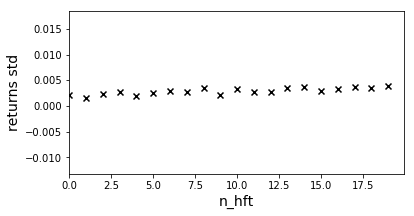

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volatility)), volatility, c='k', marker='x')

ax1.set_ylabel('returns std', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Orderbook depth increases

In [12]:
# how to measure orderbook depth? 
average_depth = []
for ob in obs:
    av_ask_depth = np.mean(ob.tick_bid_depth) #[np.mean(prices) for prices in orderbook.transaction_prices_history]
    av_bid_depth = np.mean(ob.tick_ask_depth)
    average_depth.append(av_ask_depth + av_bid_depth)

(0, 19.957096774193548)

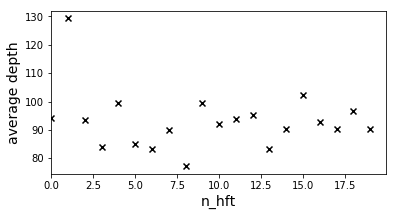

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(average_depth)), average_depth, c='k', marker='x')

ax1.set_ylabel('average depth', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Complete picture

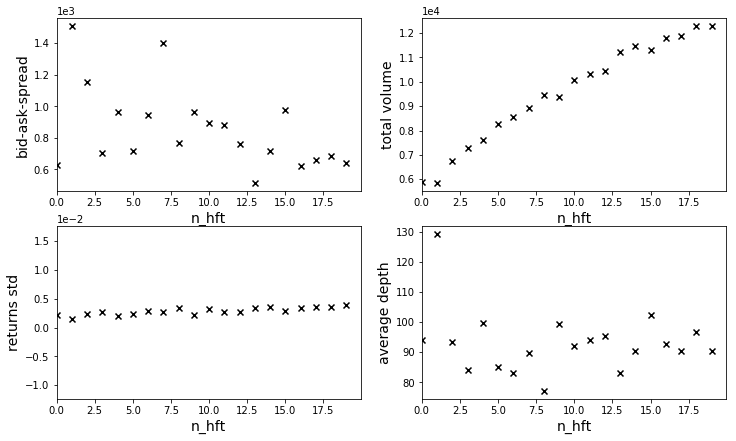

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.scatter(range(len(mean_bid_asks)), mean_bid_asks, c='k', marker='x', label='Bid-ask')

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

ax2.scatter(range(len(volume)), volume, c='k', marker='x')
ax2.set_ylabel('total volume', fontsize='14')
ax2.set_xlabel('n_hft', fontsize='14')
ax2.set_xlim(xmin=0)

ax3.scatter(range(len(volatility)), volatility, c='k', marker='x')
ax3.set_ylabel('returns std', fontsize='14')
ax3.set_xlabel('n_hft', fontsize='14')
ax3.set_xlim(xmin=0)

ax4.scatter(range(len(average_depth)), average_depth, c='k', marker='x')
ax4.set_ylabel('average depth', fontsize='14')
ax4.set_xlabel('n_hft', fontsize='14')
ax4.set_xlim(xmin=0)

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('predictions.png')

# Data analysis

In [293]:
end_tick_price = orderbook.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
total_tick_volume = [sum(volumes) for volumes in orderbook.transaction_volumes_history]
returns = pd.Series(np.array(end_tick_price)).pct_change()
autocorr_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]
absolute_returns = pd.Series(returns).abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

## Prices, returns & volume

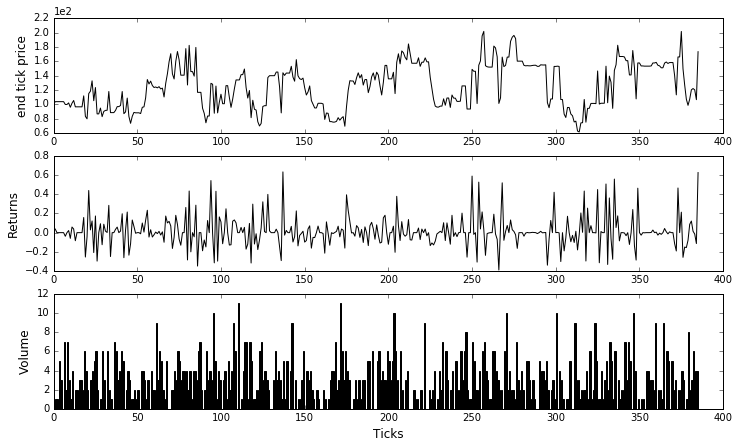

In [294]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,7))

ax1.plot(range(len(end_tick_price)), end_tick_price, 'k-')
ax1.set_ylabel('end tick price', fontsize='12')

ax2.plot(range(len(returns)), returns, 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(range(len(total_tick_volume)), total_tick_volume, color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('hfm_dynamics.png')

## Bid-ask spread & volatility

In [295]:
bid_ask = [ask - bid for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))
np.mean(bid_ask)

14.385763904727739

In [296]:
# is this the correct way 
window = 10
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns.std()

0.15826726242778535

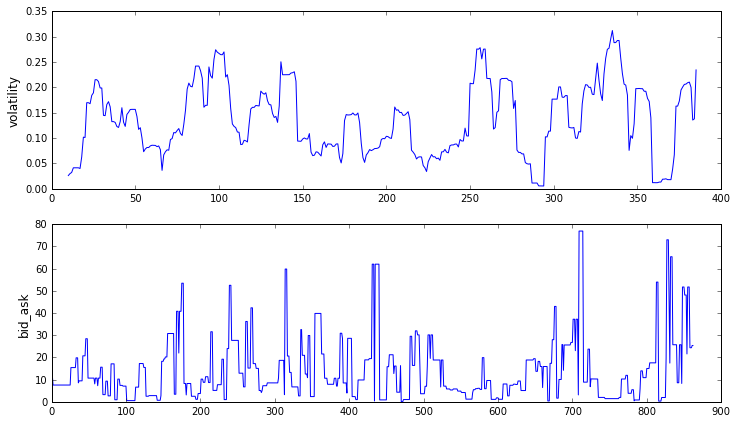

In [297]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

ax1.plot(range(len(returns_volatility)), returns_volatility)
ax1.set_ylabel('volatility', fontsize='12')

ax2.plot(range(len(bid_ask)), bid_ask)
ax2.set_ylabel('bid_ask', fontsize='12')

# Basic financial market stylized facts
## No autocorrelation in returns

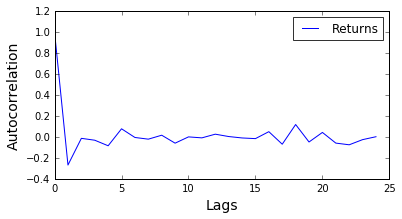

In [298]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Excess Kurtosis

In [299]:
pd.Series(returns).kurtosis()

3.0658434584117833

## Clustered volatility

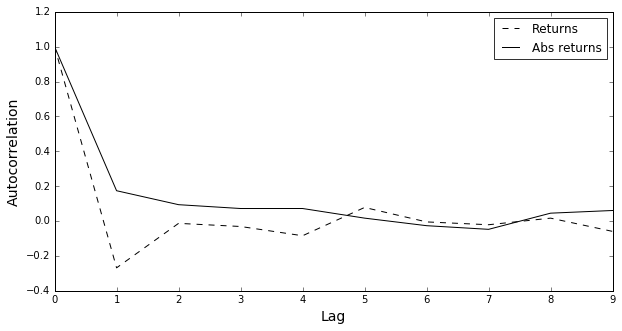

In [300]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 10

ax1.plot(range(len(autocorr_returns[:lenght])), autocorr_returns[:lenght], 'k--', label='Returns')
ax1.plot(range(len(autocorr_abs_returns[:lenght])), autocorr_abs_returns[:lenght], 'k-', label='Abs returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

#fig.savefig('auto_correlations.png')

# % of trades by HFT

In [301]:
def hft_in_match(match):
    for buy_sell in match:
        if 'HFT' in str(buy_sell):
            return True
    return False

In [302]:
amount_matched_orders = 0
hft_participating_orders = 0 
for tick in orderbook.matched_bids_history:
    amount_matched_orders += len(tick)
    for match in tick:
        if hft_in_match(match):
            hft_participating_orders += 1
        
print('total matches ', amount_matched_orders)
print('total hft matches ', hft_participating_orders)
print('percentage hft matches = ', hft_participating_orders / amount_matched_orders)

total matches  933
total hft matches  402
percentage hft matches =  0.43086816720257237


# HFT Investment

In [303]:
cum_inv = []
for hft in high_frequency_traders:
    cum_inv.append(np.array(hft.var_previous.cum_investment))

In [304]:
agg_cum_inv = np.zeros(len(cum_inv[0]))
for c_i in cum_inv:
    agg_cum_inv += c_i

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


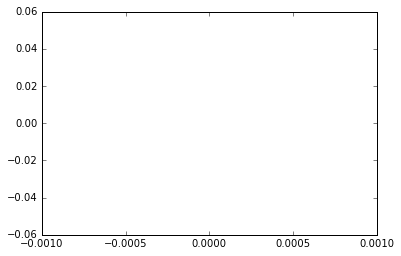

In [305]:
pd.Series(agg_cum_inv)[:100].plot()

# HFT speed

In [306]:
speed = []
for hft in high_frequency_traders:
    speed.append(np.array(hft.var_previous.speed))

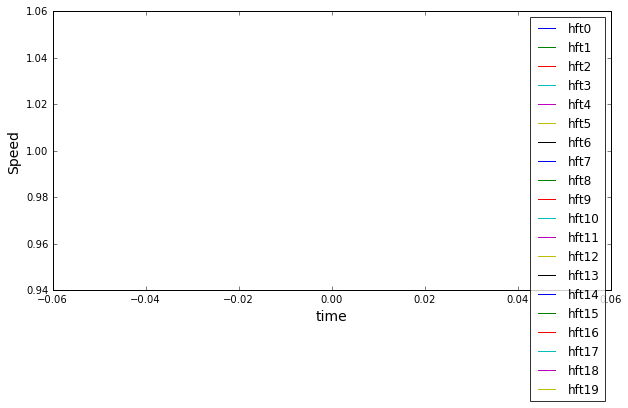

In [307]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, s in enumerate(speed):
    ax1.plot(range(len(s[:100])), s[:100], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Speed', fontsize='14')
ax1.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT profitability

Total wealth. The HFT's track their own total wealth

In [308]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

### Locked in profits

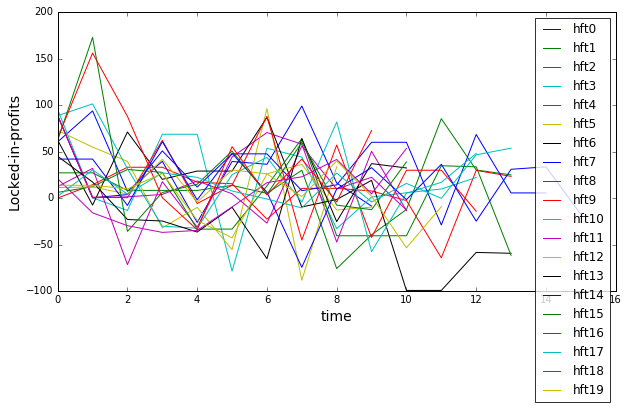

In [309]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

In [310]:
sum(locked_in_profits[0])

358.20485667636842

### Sharpe ratio

In [311]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [312]:
all_profits = np.concatenate(locked_in_profits)

In [313]:
sum(all_profits)

3670.8608675359728

In [314]:
#sharpe(len(locked_in_profits[0]), locked_in_profits[0].mean(), locked_in_profits[0].std())
sharpe(len(all_profits), all_profits.mean(), all_profits.std())

5.6677869081557333

### Wealth

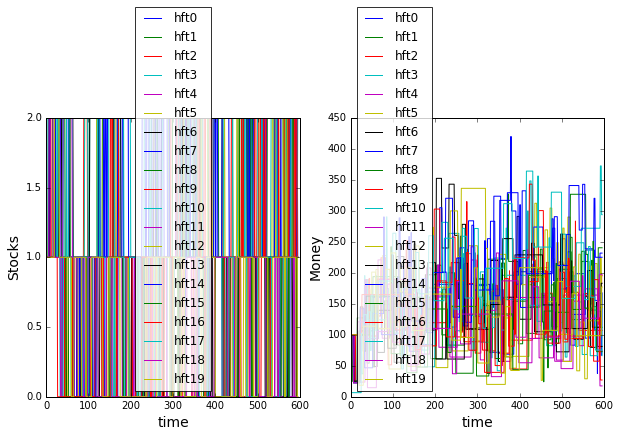

In [288]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# Orderbook depth

size of ask book? Size of bids book?

In [24]:
np.random.normal(scale=parameters['std_LFT_price'])

0.004313224404561005

# Percentage of trades by HFT vs. LFT? 